# Staging AGN and Checking Distribution

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.size'] = 14

In [9]:
combine_fold = 'C:/Users/oryan/Documents/mergers-in-cosmos/cats-to-combine'
data_folder = 'C:/Users/oryan/Documents/mergers-in-cosmos/back-to-basics-data'
fig_folder = 'C:/Users/oryan/Documents/mergers-in-cosmos/paper-source/figures'
cos_dat_fold = 'E:/cosmos-data'

### Importing Data

In [10]:
agn_cat = pd.read_csv(f'{combine_fold}/source-agn-cat.csv', index_col = 0)

In [11]:
df_cat = pd.read_csv(f'{combine_fold}/dor-all-restaged-full.csv', index_col = 0)

C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [12]:
df_cat.head()

,ORyanID_23,ID,category,ALPHA_J2000,DELTA_J2000,X_IMAGE,Y_IMAGE,ERRX2_IMAGE,ERRY2_IMAGE,ERRXY_IMAGE,...,ez_ssfr_p025,ez_ssfr_p160,ez_ssfr_p500,ez_ssfr_p840,ez_ssfr_p975,ez_Av_p025,ez_Av_p160,ez_Av_p500,ez_Av_p840,ez_Av_p975
0,4000705532455,816891,stage4,150.679846,2.196543,9200.399414,21737.232422,0.000052,0.000059,-0.000010,...,-8.931825,-8.911355,-8.899668,-8.883307,-8.872990,0.529107,0.560142,0.599624,0.630920,0.652330
1,4000705533383,860686,stage3,150.644522,2.237226,10047.978516,22713.351562,0.000051,0.000046,0.000002,...,-9.314209,-9.106611,-8.941274,-8.713107,-8.541205,0.341270,0.545498,0.732327,0.906665,1.020098
2,4000705539941,1301188,stage2,149.702462,2.654895,32637.949219,32737.013672,0.000064,0.000104,-0.000003,...,-9.794128,-9.784252,-9.766013,-9.743796,-9.727879,0.018737,0.018737,0.018737,0.018737,0.018737
3,4000705540034,1304538,stage3,149.726828,2.658172,32053.712891,32815.468750,0.000071,0.000086,-0.000006,...,-9.480532,-9.443615,-9.402433,-9.352081,-9.325659,0.302629,0.376027,0.440394,0.508153,0.567727
4,4000705540064,1310001,stage3,149.701230,2.660343,32667.441406,32867.789062,0.000026,0.000020,-0.000010,...,-9.882174,-9.855921,-9.816085,-9.697225,-9.573506,0.455258,0.482555,0.522239,0.600383,0.660279


In [13]:
agn_cat.head()

,ID,agn_clsf
0,833971,HLAGN
1,1022115,MLAGN
2,591088,MLAGN
3,840582,HLAGN
4,1158286,HLAGN


In [14]:
len(agn_cat)

1214

In [15]:
df_cat_red = df_cat[['ORyanID_23', 'lp_mass_best', 'ez_sfr', 'ID', 'category']]

In [16]:
df_merg = (
    agn_cat
    .merge(df_cat_red, on = 'ID', how = 'left')
)

### The Raw Numbers

In [17]:
print(df_merg.agn_clsf.value_counts())

SFG      812
AGN      329
HLAGN     40
MLAGN     33
Name: agn_clsf, dtype: int64


In [18]:
def agn_class(x):
    if x == 'SFG' or x == 'SF':
        return 'SFG'
    else:
        return 'AGN'

In [19]:
df_agn_simp = (
    df_merg
    .assign(agn = df_merg.agn_clsf.apply(lambda x: agn_class(x)))
)

In [20]:
for i in range(4):
    stage = f'stage{i+1}'
    df_tmp = df_agn_simp.query('category == @stage')
    print(f'Stage {i+1}')
    print(df_tmp.agn.value_counts())
    print(' ')

Stage 1
SFG    149
AGN    110
Name: agn, dtype: int64
 
Stage 2
SFG    196
AGN     81
Name: agn, dtype: int64
 
Stage 3
SFG    314
AGN    139
Name: agn, dtype: int64
 
Stage 4
SFG    153
AGN     72
Name: agn, dtype: int64
 


In [21]:
for i in range(4):
    stage = f'stage{i+1}'
    df_tmp = df_agn_simp.query('category == @stage')
    print(f'Stage {i+1}')
    print(df_tmp.agn.value_counts()['AGN'] / (df_tmp.agn.value_counts().sum()))
    print(' ')

Stage 1
0.4247104247104247
 
Stage 2
0.2924187725631769
 
Stage 3
0.3068432671081678
 
Stage 4
0.32
 


### Plotting

In [41]:
df_agn_clsf = df_merg[['ID','agn_clsf']]

In [42]:
df_agn_id_merg = (
    df_agn_clsf
    .merge(df_cat[['ID', 'lp_mass_best', 'ez_sfr', 'category']], on = 'ID', how = 'right')
    .query('lp_mass_best > 6.5')
)
df_agn_id_merg

,ID,agn_clsf,lp_mass_best,ez_sfr,category
0,816891,NaN,9.28590,0.589695,stage4
1,860686,NaN,10.44862,1.609304,stage3
2,1301188,NaN,8.72372,-0.987761,stage2
3,1304538,NaN,9.96798,1.101499,stage3
4,1310001,NaN,10.41827,1.083541,stage3
...,...,...,...,...,...
4176,1520733,NaN,9.27097,0.369745,stage4
4177,1520749,SFG,9.50357,0.507741,stage2
4178,1523385,NaN,9.53909,0.406027,stage3
4179,1524909,SFG,9.76084,0.637714,stage3


In [43]:
def get_clsf(x):
    if type(x) == str:
        return x
    elif np.isnan(x):
        return 'Unknown'
    else:
        print('Error')
        sys.exit()

In [44]:
df_reclsf = (
    df_agn_id_merg
    .assign(agn_clsf_uk = df_agn_id_merg.agn_clsf.apply(lambda x: get_clsf(x)))
    .query('ez_sfr < 5.5')
)

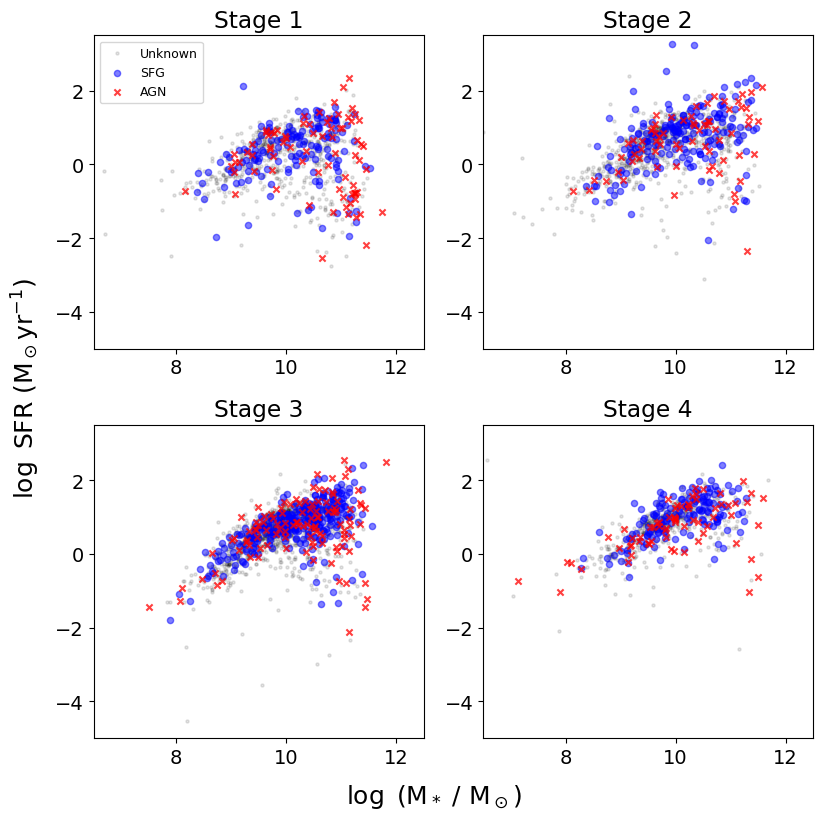

In [58]:
counter = 1
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (8,8))
alphas = [0.1, 0.5, 0.75]
markers = ['.', 'o', 'x']
agn_clsf = ['Unknown','SFG','AGN']
colours = ['black', 'blue', 'red']
for i in range(2):
    for j in range(2):
        stage = f'stage{counter}'
        df_stage = df_reclsf.query('category == @stage')
        for k, clsf in enumerate(agn_clsf):
            df = df_stage.query('agn_clsf_uk == @clsf')

            ax[i,j].scatter(np.array(df.lp_mass_best), np.array(df.ez_sfr), color = colours[k], marker = markers[k], s = 20, alpha = alphas[k])
            ax[i,j].set_title(f'Stage {counter}')
            ax[i,j].set_xlim([6.5, 12.5])
            ax[i,j].set_ylim([-5,3.5])
        
        counter += 1
ax[0,0].legend(agn_clsf, loc = 'upper left', fontsize = 9)
fig.text(0.5, -0.01, '$\log$ (M$_*$ / M$_\odot$)', ha='center', va='center', fontsize = 18)
fig.text(-0.01, 0.5, '$\log$ SFR (M$_\odot$yr$^{-1}$)', ha='center', va='center', rotation='vertical', fontsize = 18)
fig.tight_layout()
fig.savefig(f'{fig_folder}/agn-stage-dist.pdf', bbox_inches = 'tight')
plt.show()

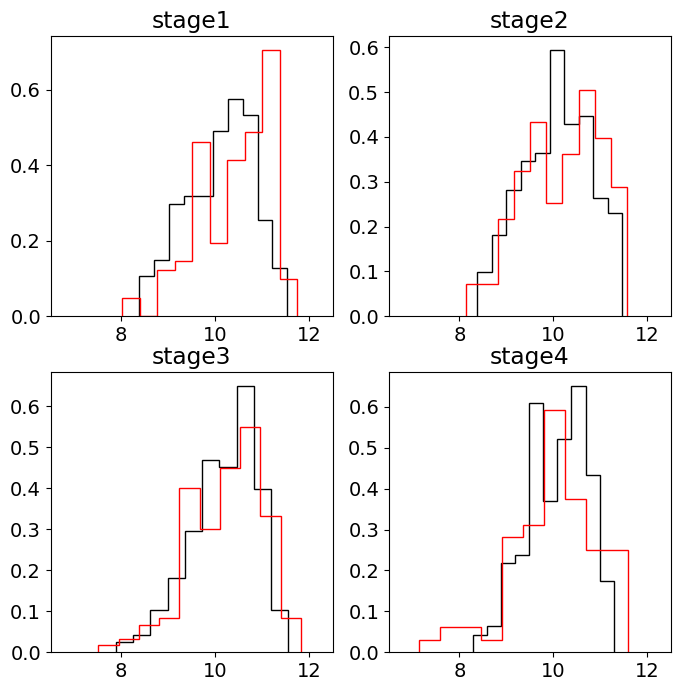

In [59]:
counter = 1
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (8,8))
for i in range(2):
    for j in range(2):
        stage = f'stage{counter}'
        df_stage = df_agn_simp.query('category == @stage')
        df_agn = df_stage.query('agn == "AGN"')
        df_sf = df_stage.query('agn == "SFG"')
        
        ax[i,j].hist(np.array(df_sf.lp_mass_best), color = 'black', histtype='step', density = True, bins = 10)#, alpha = 0.75)
        ax[i,j].hist(np.array(df_agn.lp_mass_best), color = 'red', histtype='step', density = True, bins = 10)#, alpha = 0.75)
        ax[i,j].set_title(stage)
        ax[i,j].set_xlim([6.5, 12.5])
        
        counter += 1

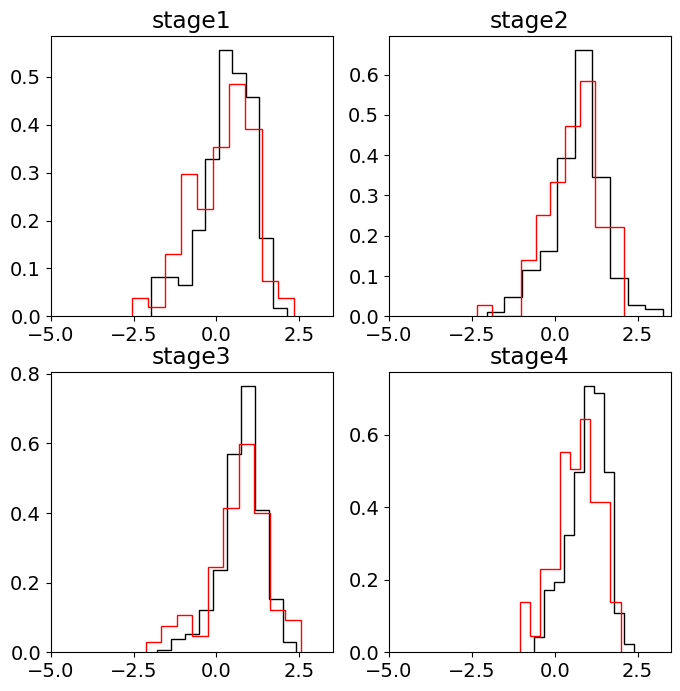

In [62]:
counter = 1
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (8,8))
for i in range(2):
    for j in range(2):
        stage = f'stage{counter}'
        df_stage = df_agn_simp.query('category == @stage')
        df_agn = df_stage.query('agn == "AGN"')
        df_sf = df_stage.query('agn == "SFG"')
        
        ax[i,j].hist(np.array(df_sf.ez_sfr), color = 'black', histtype='step', bins = 10, density = True)#, alpha = 0.75)
        ax[i,j].hist(np.array(df_agn.ez_sfr), color = 'red', histtype='step', bins = 10, density = True)#, alpha = 0.75)
        ax[i,j].set_title(stage)
        ax[i,j].set_xlim([-5, 3.5])
        
        counter += 1

So, galaxies with lower SF gain AGN as we go to higher stages. This is an interesting result! And points to interaction definitively having an impact on AGN, but only as coalescence approaches. So, how do we prove this / make sure it's not due to selection effects?